Exploring the Meteorological Service of Canada (MSC) open data api to pull weather data for a specific location.

References:
* [Example API usage notebook](https://mybinder.org/v2/gh/ECCC-MSC/open-data/master?filepath=docs%2Fusage%2Fuse-case_arthur%2Fuse-case_arthur_en.ipynb)
* [MSC GeoMet swagger API documentation](https://api.weather.gc.ca/openapi?f=html)
* [MSC GeoMet Technical documentation](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/)
* [OWSLib - WebMapService usage](https://geopython.github.io/OWSLib/usage.html#wms)
* [Canadian Surface Prediction Archive](https://github.com/julemai/CaSPAr)
* [University of Saskatchewan wiki - modelling data catalogue](https://wiki.usask.ca/display/MDC/Modelling+Data+Catalogue+Home)


In [1]:
# Importation of Python modules
from datetime import datetime, timedelta
import re
import warnings
from typing import List

# The following modules must first be installed to use
# this code out of Jupyter Notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy
from owslib.wms import WebMapService
import pandas
from tabulate import tabulate

# Ignore warnings from the OWSLib module
warnings.filterwarnings("ignore", module="owslib", category=UserWarning)

# Parameters choice
# Layer:
layer = "REPS.DIAG.3_PRMM.ERGE5"
# Coordinates:
y, x = 43.59739, -79.50574
# Local time zone (in this exemple, the local time zone is UTC-05:00):
time_zone = -5

In [2]:
# bbox parameter
min_x, min_y, max_x, max_y = x - 0.25, y - 0.25, x + 0.25, y + 0.25

In [3]:
# WMS service connection
wms = WebMapService(
    "https://geo.weather.gc.ca/geomet?SERVICE=WMS" + "&REQUEST=GetCapabilities",
    version="1.3.0",
    timeout=300,
)

In [4]:
# Extraction of temporal information from metadata
def time_parameters(layer: str) -> tuple[datetime, datetime, int]:
    """Get start, end date and interval of forecast information"""
    start_time, end_time, interval = (
        wms[layer].dimensions["time"]["values"][0].split("/")
    )
    iso_format = "%Y-%m-%dT%H:%M:%SZ"
    start_time = datetime.strptime(start_time, iso_format)
    end_time = datetime.strptime(end_time, iso_format)
    interval = int(re.sub(r"\D", "", interval))
    return start_time, end_time, interval


start_time, end_time, interval = time_parameters(layer)

# To use specific starting and ending time, remove the #
# from the next lines and replace the start_time and
# end_time with the desired values:
# start_time = 'YYYY-MM-DDThh:00'
# end_time = 'YYYY-MM-DDThh:00'
# fmt = '%Y-%m-%dT%H:%M'
# start_time = datetime.strptime(start_time, fmt) - timedelta(hours=time_zone)
# end_time = datetime.strptime(end_time, fmt) - timedelta(hours=time_zone)

# Calculation of date and time for available predictions
# (the time variable represents time at UTC±00:00)
time = [start_time]
local_time = [start_time + timedelta(hours=time_zone)]
while time[-1] < end_time:
    time.append(time[-1] + timedelta(hours=interval))
    local_time.append(time[-1] + timedelta(hours=time_zone))

In [5]:
wms[layer].dimensions

{'time': {'units': 'ISO8601',
  'default': '2022-12-15T15:00:00Z',
  'nearestValue': '0',
  'values': ['2022-12-15T15:00:00Z/2022-12-18T12:00:00Z/PT3H']},
 'reference_time': {'units': 'ISO8601',
  'default': '2022-12-15T12:00:00Z',
  'multipleValues': '1',
  'nearestValue': '0',
  'values': ['2022-12-13T12:00:00Z/2022-12-15T12:00:00Z/PT6H']}}

In [6]:
# Get the layers and their titles.
# Review this list to identify which layers contains the information you need
for item in list(wms.contents):
    print(item, ":", wms[item].title)

Canadian Weather : Canadian Weather
ALERTS : Weather Alerts [experimental]
CURRENT_CONDITIONS : Current Conditions
METNOTES : MetNotes
Regional Deterministic Prediction System (RDPS) [10 km] : Regional Deterministic Prediction System (RDPS) [10 km]
RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL) : RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
CGSL.ETA_ICEC : CGSL.ETA.ICEC - Ice cover fraction
CGSL.ETA_ICEPRS : CGSL.ETA.ICEPRS - Vertically integrated ice internal pressure (or stress) [N/m]
CGSL.ETA_ICESTG : CGSL.ETA.ICESTG - Vertically integrated compressive ice strength [N/m]
CGSL.ETA_ICET : CGSL.ETA.ICET - Ice surface temperature [K]
CGSL.ETA_ICETK : CGSL.ETA.ICETK - Ice thickness [m]
CGSL.ETA_UICE : CGSL.ETA.UICE - Ice speed vector [m/s]
CGSL.ETA_UOGRD : CGSL.ETA.UOGRD - Surface ocean current [m/s]
CGSL.ETA_UU : CGSL.ETA.UU - Wind at surface level [m/s]
CGSL.ETA_WTMP : CGSL.ETA.WTMP - Water temperature [K]
RDPS convective fields : RDPS convective fields
RDPS.CONV_KINDEX.PT3H 

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io

for timestep in time:
    img = wms.getmap(
        layers=[layer],
        styles=["default"],
        srs="EPSG:4326",
        bbox=(min_x, min_y, max_x, max_y),
        size=(500, 500),
        format="image/jpeg",
        transparent=True,
        # info_format="text/plain",
        # feature_count=1,
        time=str(timestep.isoformat()) + "Z",
    )

    with open(f"img {timestep}.jpg", "wb") as f:
        f.write(img.read())
# img.read()


In [8]:
wms = WebMapService('http://webservices.nationalatlas.gov/wms/1million',\
                                    version='1.3.0')
img = wms.getmap(layers=['airports1m'],\
                        styles=['default'],\
                        srs='EPSG:4326',\
                        bbox=(-176.646, 17.7016, -64.8017, 71.2854),\
                        size=(300, 300),\
                        format='image/jpeg',\
                        transparent=True)
Image(img.read())

ConnectionError: HTTPConnectionPool(host='webservices.nationalatlas.gov', port=80): Max retries exceeded with url: /wms/1million?service=WMS&request=GetCapabilities&version=1.3.0 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fde29d9d600>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
# Loop to carry out the requests and extract the probabilities
def request(layer: str, timesteps:list[datetime]) -> List:
    info = []
    pixel_value = []
    for timestep in timesteps:
        # WMS GetFeatureInfo query
        info.append(
            wms.getfeatureinfo(
                layers=[layer],
                srs="EPSG:4326",
                bbox=(min_x, min_y, max_x, max_y),
                size=(100, 100),
                format="image/jpeg",
                query_layers=[layer],
                info_format="text/plain",
                xy=(50, 50),
                feature_count=1,
                time=str(timestep.isoformat()) + "Z",
            )
        )
        # Probability extraction from the request's results
        text = info[-1].read().decode("utf-8")
        pixel_value.append(str(re.findall(r"value_0\s+\d*.*\d+", text)))
        pixel_value[-1] = float(
            re.sub(pattern="value_0 = '", repl="", string=pixel_value[-1]).strip('[""]')
        )

    return pixel_value


pixel_value = request(layer, time)

In [ ]:
wms.getfeatureinfo(
                layers=[layer],
                srs="EPSG:4326",
                bbox=(min_x, min_y, max_x, max_y),
                size=(100, 100),
                format="image/jpeg",
                query_layers=[layer],
                info_format="text/plain",
                xy=(50, 50),
                feature_count=1,
                time=str(time[0].isoformat()) + "Z",
            ).read()

b"GetFeatureInfo results:\n\nLayer 'REPS.DIAG.3_PRMM.ERGE5'\n  Feature 0: \n    x = '-79.583334'\n    y = '43.595573'\n    value_0 = '0'\n    value_list = '0'\n    class = '0'\n    red = '0'\n    green = '0'\n    blue = '0'\n"

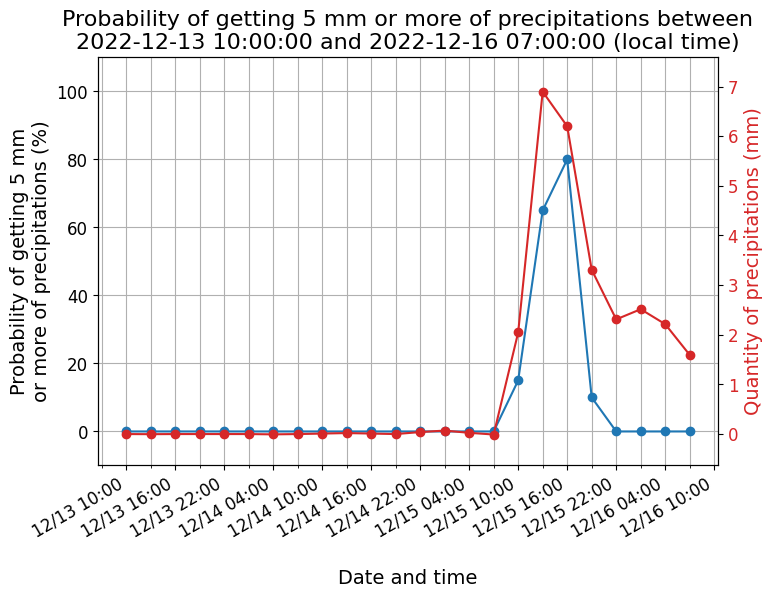

In [ ]:
# Function to adjust the alignment of two y axis
import ntpath
from typing import Iterable, Optional
import numpy.typing as npt


def align_yaxis(ax: plt.Axes, ax2: plt.Axes) -> None:
    y_lims = numpy.array([ax.get_ylim() for ax in [ax, ax2]])

    # Normalize both y axis
    y_magnitudes = (y_lims[:, 1] - y_lims[:, 0]).reshape(len(y_lims), 1)
    y_lims_normalized = y_lims / y_magnitudes

    # Find combined range
    y_new_lims_normalized = numpy.array(
        [numpy.min(y_lims_normalized), numpy.max(y_lims_normalized)]
    )

    # Denormalize combined range to get new axis
    new_lim1, new_lim2 = y_new_lims_normalized * y_magnitudes
    ax2.set_ylim(new_lim2)


# Function to create the plot
def fig(
    x: Iterable,
    y: Iterable,
    title: str,
    xlabel: str,
    ylabel: str,
    ylim: float,
    color: str = "black",
    y2: Optional[Iterable] = "",
    y2label: str = "",
):
    # Plot and text size parameters
    params = {
        "legend.fontsize": "14",
        "figure.figsize": (8, 6),
        "axes.labelsize": "14",
        "axes.titlesize": "16",
        "xtick.labelsize": "12",
        "ytick.labelsize": "12",
    }
    plt.rcParams.update(params)

    # Plot creation and plot styling
    fig, ax = plt.subplots()
    ax.plot(x, y, marker="o")

    # Titles
    plt.title(title)
    plt.xlabel(xlabel)
    ax.set_ylabel(ylabel, color=color)

    # Y axis range
    ax.set_ylim(ylim)
    ax.tick_params(axis="y", labelcolor=color)

    # Grid
    plt.grid(True, which="both")

    # Add a second dataset
    if y2 is not None:
        ax2 = plt.twinx()
        ax2.plot(x, y2, marker="o", color="tab:red")
        # Second y axis title
        ax2.set_ylabel(y2label, color="tab:red")
        # Range and ticks of second y axis
        ax2.set_ylim(0, (max(y2) * 1.1))
        ax2.tick_params(axis="y", labelcolor="tab:red")
        align_yaxis(ax, ax2)

    # Date format on x axis
    plt.gcf().autofmt_xdate()
    my_format = mdates.DateFormatter("%m/%d %H:%M")
    plt.gca().xaxis.set_major_formatter(my_format)

    # Graduation of x axis depending on the number of values plotted
    # Variable containing the hours for which there will be ticks:
    hour = []
    for timestep in x:
        hour.append(int(timestep.strftime("%#H")))

    # Frequency of ticks and labels on the x axis
    if len(hour) < 8:
        # More precise graduation if there is only a few values plotted
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=hour))
    elif len(hour) > 8 and len(hour) < 25:
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=hour, interval=2))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=hour))
    else:
        # Coarser graduation if there is a lot of values plotted
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=(0, 12)))

    return fig


# Add quantity of precipitations to the plot
# Verification of temporal parameters compatibility:
start_time1, end_time1, interval1 = time_parameters("REPS.DIAG.3_PRMM.ERMEAN")

if start_time1 == start_time and end_time1 == end_time and interval1 == interval:
    # GetFeatureInfo request
    y2 = request(layer="REPS.DIAG.3_PRMM.ERMEAN", timesteps=time)
    y2label = "Quantity of precipitations (mm)"
else:
    y2 = None
    y2label = ""

# Create the plot with the fig function and show the plot
fig(
    x=local_time,
    y=pixel_value,
    title=(
        "Probability of getting 5 mm or more of precipitations between"
        + f"\n{local_time[0]} and {local_time[-1]} (local time)"
    ),
    xlabel="\nDate and time",
    ylabel="Probability of getting 5 mm\nor more of precipitations (%)",
    ylim=(-10, 110),
    y2=y2,
    y2label=y2label,
)

plt.show()